In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from carl.distributions import Mixture, MultivariateNormal
p = Mixture(components=[MultivariateNormal(mu=np.array([0., 2.]), sigma=np.eye(2)), 
                        MultivariateNormal(mu=np.array([0., -2.]), sigma=np.eye(2))])
q0 = MultivariateNormal(mu=np.array([1., 0.]), sigma=np.eye(2))
q1 = MultivariateNormal(mu=np.array([-2., 0.]), sigma=np.eye(2))
q_full = Mixture(components=[q0, q1])

In [3]:
n_samples = 25000

X0 = np.vstack([p.rvs(n_samples), q0.rvs(n_samples)])
y0 = np.zeros(len(X0))
y0[len(X0) // 2:] = 1

X1 = np.vstack([p.rvs(n_samples), q1.rvs(n_samples)])
y1 = np.zeros(len(X0))
y1[len(X1) // 2:] = 1

X = np.vstack([X0, X1])
y = np.concatenate([y0, y1])
z = np.zeros(len(X))
z[len(X0):] = 1

In [4]:
X.shape, y.shape, z.shape

((100000, 2), (100000,), (100000,))

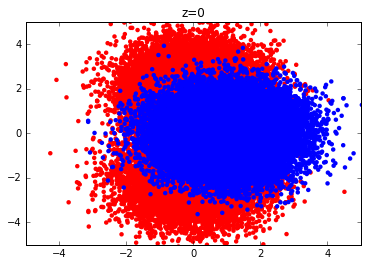

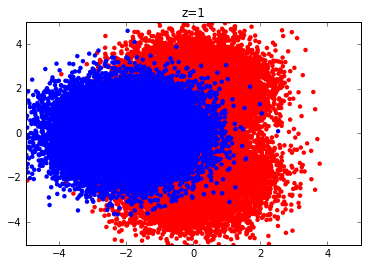

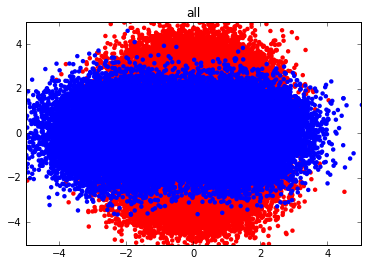

In [5]:
plt.title("z=0")
plt.scatter(X0[y0==0, 0], X0[y0==0, 1], c="r", marker="o", edgecolors="none")
plt.scatter(X0[y0==1, 0], X0[y0==1, 1], c="b", marker="o", edgecolors="none")
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.show()

plt.title("z=1")
plt.scatter(X1[y1==0, 0], X1[y1==0, 1], c="r", marker="o", edgecolors="none")
plt.scatter(X1[y1==1, 0], X1[y1==1, 1], c="b", marker="o", edgecolors="none")
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.show()

plt.title("all")
plt.scatter(X[y==0, 0], X[y==0, 1], c="r", marker="o", edgecolors="none")
plt.scatter(X[y==1, 0], X[y==1, 1], c="b", marker="o", edgecolors="none")
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.show()

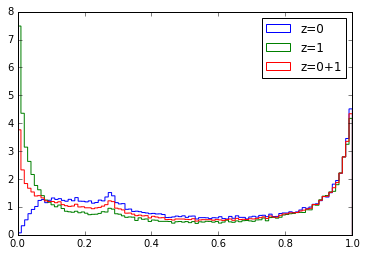

In [6]:
# best model trained on union
d = p.pdf(X0) / (p.pdf(X0) + q_full.pdf(X0))
plt.hist(d, bins=100, histtype="step", label="z=0", normed=1)
d = p.pdf(X1) / (p.pdf(X1) + q_full.pdf(X1))
plt.hist(d, bins=100, histtype="step", label="z=1", normed=1)
d = p.pdf(X) / (p.pdf(X) + q_full.pdf(X))
plt.hist(d, bins=100, histtype="step", label="z=0+1", normed=1)
plt.legend(loc="best")
plt.show()

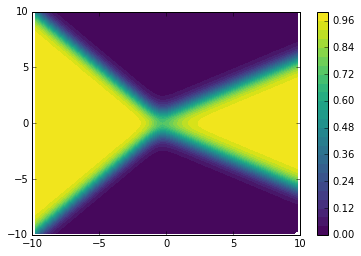

In [7]:
X_test = np.random.rand(25000, 2)
X_test[:, 0] *= 20. 
X_test[:, 0] -= 10.
X_test[:, 1] *= 20. 
X_test[:, 1] -= 10.
y_pred = q_full.pdf(X_test) / (p.pdf(X_test) + q_full.pdf(X_test))

from matplotlib.mlab import griddata
xi = np.linspace(-10, 10., 100)
yi = np.linspace(-10, 10., 200)
zi = griddata(X_test[:, 0], X_test[:, 1], y_pred, xi, yi, interp="linear")
CS = plt.contourf(xi, yi, zi, 25, cmap=plt.cm.viridis,
                  vmax=1.0, vmin=0.0)
plt.colorbar() 

In [8]:
from sklearn.metrics import roc_auc_score
(roc_auc_score(y0, q_full.pdf(X0) / (p.pdf(X0) + q_full.pdf(X0))), 
 roc_auc_score(y1, q_full.pdf(X1) / (p.pdf(X1) + q_full.pdf(X1))),
 roc_auc_score(y, q_full.pdf(X) / (p.pdf(X) + q_full.pdf(X))))

(0.87092487759999992, 0.92964482240000001, 0.9000322972)

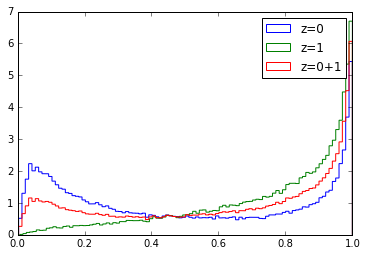

In [9]:
# best model trained on z=0
d = p.pdf(X0) / (p.pdf(X0) + q0.pdf(X0))
plt.hist(d, bins=100, histtype="step", label="z=0", normed=1)
d = p.pdf(X1) / (p.pdf(X1) + q0.pdf(X1))
plt.hist(d, bins=100, histtype="step", label="z=1", normed=1)
d = p.pdf(X) / (p.pdf(X) + q0.pdf(X))
plt.hist(d, bins=100, histtype="step", label="z=0+1", normed=1)
plt.legend(loc="best")
plt.show()

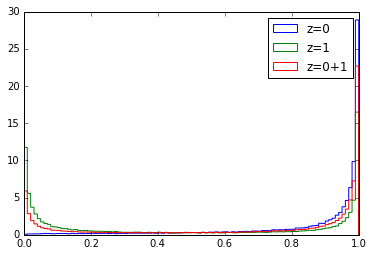

In [10]:
# best model trained on z=1
d = p.pdf(X0) / (p.pdf(X0) + q1.pdf(X0))
plt.hist(d, bins=100, histtype="step", label="z=0", normed=1)
d = p.pdf(X1) / (p.pdf(X1) + q1.pdf(X1))
plt.hist(d, bins=100, histtype="step", label="z=1", normed=1)
d = p.pdf(X) / (p.pdf(X) + q1.pdf(X))
plt.hist(d, bins=100, histtype="step", label="z=0+1", normed=1)
plt.legend(loc="best")
plt.show()

None of these variations are pivotal!

In [27]:
import keras.backend as K
from keras.layers import Input, Dense
from keras.models import Model

inputs = Input(shape=(X.shape[1],))
Dx = Dense(24, activation="tanh")(inputs)
Dx = Dense(24, activation="relu")(Dx)
Dx = Dense(1, activation="sigmoid")(Dx)
D = Model(input=[inputs], output=[Dx])

Rx = D(inputs)
Rx = Dense(24, activation="tanh")(Rx)
Rx = Dense(24, activation="relu")(Rx)
Rx = Dense(1, activation="sigmoid")(Rx)
R = Model(input=[inputs], output=[Rx])

In [28]:
from keras.optimizers import Adam, SGD

def make_loss_D(c):
    def loss_D(y_true, y_pred):
        y_true = y_true.ravel()
        y_pred = y_pred.ravel()
        return c * ((1.0 - y_true) * (K.log(1.0 - y_pred)) + (y_true) * (K.log(y_pred))) 

    return loss_D

def make_loss_R(c):
    def loss_R(z_true, z_pred):
        z_true = z_true.ravel()
        z_pred = z_pred.ravel()
        return c * ((1.0 - z_true) * (K.log(1.0 - z_pred)) + (z_true) * (K.log(z_pred)))
    
    return loss_R

opt_DRf = Adam() #SGD(lr=10e-3, momentum=0.1)
DRf = Model(input=[inputs], output=[D(inputs), R(inputs)])
DRf.compile(loss=[make_loss_D(c=-1.0), 
                  make_loss_R(c=10.0)],   # compare with c=0.0, ie. when no there is no adversary
            optimizer=opt_DRf)

opt_DfR = Adam() #SGD(lr=10e-3, momentum=0.1)
DfR = Model(input=[inputs], output=[R(inputs)])
DfR.compile(loss=[make_loss_R(c=-1.0)], 
            optimizer=opt_DfR)

In [29]:
DRf.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_4 (InputLayer)             (None, 2)             0                                            
____________________________________________________________________________________________________
model_13 (Model)                 (None, 1)             697         input_4[0][0]                    
____________________________________________________________________________________________________
model_14 (Model)                 (None, 1)             1370        input_4[0][0]                    
Total params: 2067
____________________________________________________________________________________________________


In [30]:
DfR.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_4 (InputLayer)             (None, 2)             0                                            
____________________________________________________________________________________________________
model_14 (Model)                 (None, 1)             1370        input_4[0][0]                    
Total params: 1370
____________________________________________________________________________________________________


In [31]:
DRf.predict(X[:3])

[array([[ 0.58064091],
        [ 0.59076041],
        [ 0.52493149]], dtype=float32), array([[ 0.47891921],
        [ 0.47856218],
        [ 0.48089385]], dtype=float32)]

In [33]:
DfR.predict(X[:3])

array([[ 0.47891921],
       [ 0.47856218],
       [ 0.48089385]], dtype=float32)

In [34]:
# Pretraining
D.trainable = False
R.trainable = True
DfR.fit(X, z, nb_epoch=10)

Epoch 1/10
100000/100000 [==============================] - 1s - loss: 0.6248     
Epoch 2/10
100000/100000 [==============================] - 1s - loss: 0.5946     
Epoch 3/10
100000/100000 [==============================] - 1s - loss: 0.5927     
Epoch 4/10
100000/100000 [==============================] - 1s - loss: 0.5912     
Epoch 5/10
100000/100000 [==============================] - 1s - loss: 0.5906     
Epoch 6/10
100000/100000 [==============================] - 1s - loss: 0.5900     
Epoch 7/10
100000/100000 [==============================] - 1s - loss: 0.5900     
Epoch 8/10
100000/100000 [==============================] - 1s - loss: 0.5898     
Epoch 9/10
100000/100000 [==============================] - 1s - loss: 0.5898     
Epoch 10/10
100000/100000 [==============================] - 1s - loss: 0.5898     


In [35]:
from IPython import display

def plot_losses(i, losses):
    display.clear_output(wait=True)
    display.display(plt.gcf())

    plt.title("iteration = %d" % i)
    
    for label, values in losses.items():
        plt.plot(range(len(values)), values, label=label)
        
    plt.legend(loc="best")
    plt.show()

In [36]:
losses = {"L_d": [], "L_r": [], "L_d - L_r": []}

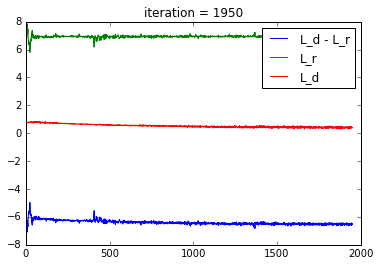

In [37]:
batch_size = 128

for i in range(2000):
    if i % 50 == 0:
        plot_losses(i, losses)
    
    # Fit D
    D.trainable = True
    R.trainable = False
    indices = np.random.permutation(len(X))[:batch_size]
    l = DRf.train_on_batch(X[indices], [y[indices], z[indices]])
    
    losses["L_d - L_r"].append(l[0][None][0])
    losses["L_d"].append(l[1][None][0])
    losses["L_r"].append(-l[2][None][0])
    
    # Fit R
    D.trainable = False
    R.trainable = True
#     DfR.fit(X, z, nb_epoch=3, verbose=0)
    
    for j in range(20):
        indices = np.random.permutation(len(X))[:batch_size]
        DfR.train_on_batch(X[indices], z[indices])

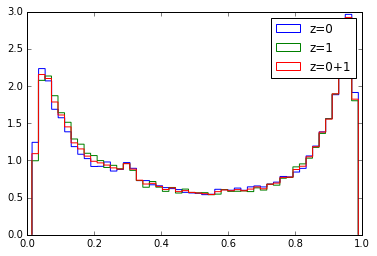

In [38]:
plt.hist(1. - D.predict(X0), bins=50, normed=1, histtype="step", label="z=0")
plt.hist(1. - D.predict(X1), bins=50, normed=1, histtype="step", label="z=1")
plt.hist(1. - D.predict(X), bins=50, normed=1, histtype="step", label="z=0+1")
plt.legend()
plt.show()

Looks pivotal!

In [39]:
X_test = np.random.rand(25000, 2)
X_test[:, 0] *= 20. 
X_test[:, 0] -= 10.
X_test[:, 1] *= 20. 
X_test[:, 1] -= 10.
y_pred = D.predict(X_test).ravel()

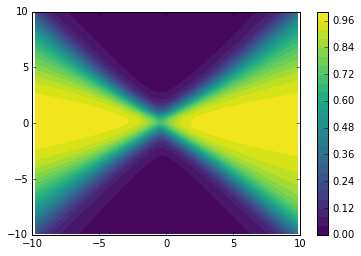

In [40]:
from matplotlib.mlab import griddata
xi = np.linspace(-10, 10., 100)
yi = np.linspace(-10, 10., 200)
zi = griddata(X_test[:, 0], X_test[:, 1], y_pred, xi, yi, interp="linear")
CS = plt.contourf(xi, yi, zi, 25, cmap=plt.cm.viridis,
                  vmax=1.0, vmin=0.0)
plt.colorbar() 

In [41]:
from sklearn.metrics import roc_auc_score
(roc_auc_score(y0, D.predict(X0)), 
 roc_auc_score(y1, D.predict(X1)), 
 roc_auc_score(y, D.predict(X)))

(0.88735008319999997, 0.88931536079999995, 0.88832275539999994)